In [1]:
%matplotlib inline

# Basic micromagnetics

In [2]:
import fenics as df
import numpy as np
import matplotlib.pyplot as plt

# Material parameters
Ms = 8.6e5  # saturation magnetisation (A/m)
alpha = 0.1  # Gilbert damping
gamma = 2.211e5  # gyromagnetic ratio
A = 1e-11 # exchange constant (J/m)

# External magentic field.
B = 0.1  # (T)
mu0 = 4 * np.pi * 1e-7  # vacuum permeability

# Zeeman field
H = Ms / 2 * df.Constant((0,0,1))
# meaningful time period is of order of nano seconds
dt = 1e-12
t_array = np.arange(0, 5e-9, dt)

############
# Simulation
############

# mesh parameters
d = 10e-9
thickness = 10e-9
nx = ny = 2
nz = 1

# create mesh
p1 = df.Point(0, 0, 0)
p2 = df.Point(d, d, thickness)
mesh = df.BoxMesh(p1, p2, nx, ny, nz)

# define function space for magnetization
V = df.VectorFunctionSpace(mesh, "CG", 1, dim=3)

# define initial M and normalise
m_init = df.Constant((1, 0, 0))
# define initial value
m = df.interpolate(m_init, V)
v = df.TestFunction(V)
volume = df.assemble(df.dot(v, df.Constant((1, 1, 1))) * df.dx).array()

def energy_density(m):
    w_Zeeman = - mu0 * Ms * df.dot(m, H)
    w_exchange = A  * df.inner(df.grad(m), df.grad(m))
    w = w_Zeeman + w_exchange
    return w

def effective_field(w, m, volume=None):
    return - 1/mu0 * df.derivative(w / Ms * df.dx, m)
    # snippet for box method: [do we need it??]
    # Heff = df.assemble(dE_dm).array()/volume

def LLG(Heff, m, alpha, gamma):
    tmp1 = -gamma/(1+alpha*alpha)*df.cross(m, Heff) - alpha*gamma/(1+alpha*alpha)*df.cross(m, df.cross(m, Heff))
    # get form that can be turned into vector using 'assemble'
    dmdt = df.dot(tmp1, df.TestFunction(V)) * df.dP
    #print("Current m(0,0,0) is {}".format(m((0,0,0))))
    return dmdt
    
def turn_form_to_function(form, vectorspace):
    """Given a form, compute a function, by projecting the form and the
    desired solution u_sol onto test functions.
    
    This can probably be done more effeciently; review later.
    """
    V = vectorspace
    u = df.TrialFunction(V)
    v = df.TestFunction(V)
    a = df.dot(u, v) * df.dx
    L = form * v 
    u_sol = df.Function(V)
    df.solve(a==L, u_sol)
    return u_sol

def compute_dmdt(m):
    """Convenience function that does all in one go"""
    Heff_function = turn_form_to_function(Heff_form, V)
    dmdt = LLG(Heff_function, m, alpha, gamma)
    return dmdt

                        
w = energy_density(m)
Heff_form = effective_field(w, m)

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
# to better understand
Heff = turn_form_to_function(Heff_form, V)
dmdt = LLG(Heff, m, alpha, gamma)
dmdt_vec = df.assemble(dmdt)

In [4]:
dmdt_vec.array()

array([  0.00000000e+00,   9.41316832e+10,   9.41316832e+09,
         0.00000000e+00,   9.41316832e+10,   9.41316832e+09,
         0.00000000e+00,   9.41316832e+10,   9.41316832e+09,
         0.00000000e+00,   9.41316832e+10,   9.41316832e+09,
         0.00000000e+00,   9.41316832e+10,   9.41316832e+09,
         0.00000000e+00,   9.41316832e+10,   9.41316832e+09,
         0.00000000e+00,   9.41316832e+10,   9.41316832e+09,
         0.00000000e+00,   9.41316832e+10,   9.41316832e+09,
         0.00000000e+00,   9.41316832e+10,   9.41316832e+09,
         0.00000000e+00,   9.41316832e+10,   9.41316832e+09,
         0.00000000e+00,   9.41316832e+10,   9.41316832e+09,
         0.00000000e+00,   9.41316832e+10,   9.41316832e+09,
         0.00000000e+00,   9.41316832e+10,   9.41316832e+09,
         0.00000000e+00,   9.41316832e+10,   9.41316832e+09,
         0.00000000e+00,   9.41316832e+10,   9.41316832e+09,
         0.00000000e+00,   9.41316832e+10,   9.41316832e+09,
         0.00000000e+00,

In [5]:
m.vector().array()

array([ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,
        0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,
        0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,
        1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,
        0.,  0.])

## Attempt to get time integration going
Start with non-micromagnetic example

In [6]:
def rhs_exp(y, t):
    dydt = -y   # enter ODE here
    return dydt

def Euler(f, y0, t0=0, dt=0.1, n=10):
    """f is the rhs function with signature f(y, t)"""
    ts = [t0]
    ys = [y0]
    t = t0
    y = y0
    for i in range(n):
        dydt = f(y, t)
        y = y + dydt * dt
        # store results
        t = t + dt
        ts.append(t)
        ys.append(y)
    return ts, ys

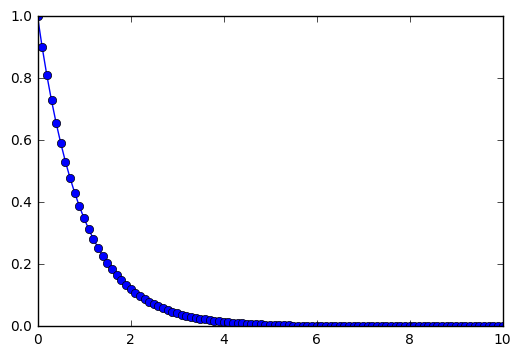

In [7]:
ts, ys = Euler(rhs_exp, y0=1, t0=0, n=100)
import pylab
pylab.plot(ts, ys, 'o-')

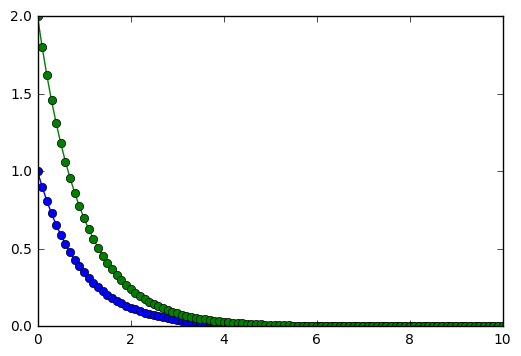

In [8]:
ts, ys = Euler(rhs_exp, y0=np.array([1, 2]), t0=0, n=100)
import pylab
pylab.plot(ts, ys, 'o-')

## Micromagnetic time integration with Euler

In [9]:
%%time
m_init = df.Constant((1, 0, 0))
m = df.interpolate(m_init, V)

def rhs_micromagnetic(m_vector_array, t):
    # convert m_vector into function
    assert isinstance(m_vector_array, np.ndarray)
    m.vector()[:] = m_vector_array[:]
    dmdt = compute_dmdt(m)
    # convert to vector
    dmdt_vector = df.assemble(dmdt)
    return dmdt_vector.array()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 471 µs


In [10]:
%%time
ts, ms = Euler(rhs_micromagnetic, y0=m.vector().array(), t0=0, dt=1e-12, n=500)

CPU times: user 7.2 s, sys: 420 ms, total: 7.62 s
Wall time: 7.76 s


In [11]:
ts;

In [12]:
ms;

In [13]:
all_m = np.array(ms)

In [14]:
all_m.shape

(501, 54)

In [15]:
tmp1 = all_m[:,0:3]  # might be m_x, m_y, m_z of first vector

In [16]:
tmp1;

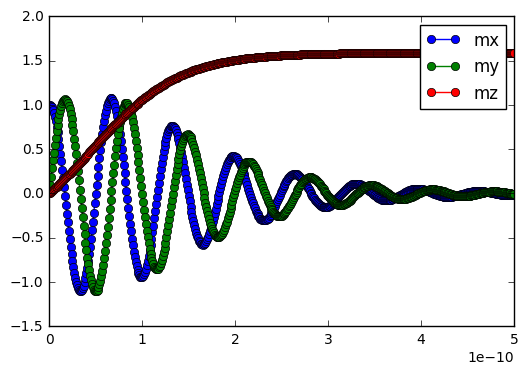

In [17]:
pylab.plot(ts, tmp1, 'o-')
pylab.legend(['mx', 'my', 'mz'])

## Repeat with scipy.integrate instead of Euler

In [18]:
from scipy.integrate import odeint

In [19]:
%%time 
m_init = df.Constant((1, 0, 0))
m = df.interpolate(m_init, V)
ts = np.linspace(0, 5e-10, 100)
ms, status = odeint(rhs_micromagnetic, y0=m.vector().array(), t=ts, full_output=1)

CPU times: user 9.18 s, sys: 600 ms, total: 9.78 s
Wall time: 10.4 s


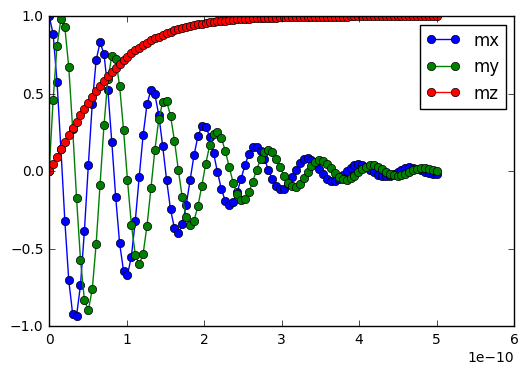

In [20]:
tmp2 = ms[:,0:3]  # might be m_x, m_y, m_z of first vector
pylab.plot(ts, tmp2, 'o-')
pylab.legend(['mx', 'my', 'mz'])

Note that odeint seems to be slower but produces a much more accurate result.

# TODO

- check constants in LLG etc
- add normalisation term in LLG (magnitude currently grows beyond 1.0)
- include macro spin test case (analytic result), and compare with computation here. Write a test for this.
- check (visually?) that we get sensible dynamics for a non-uniform starting configuration
- find problem that exhibits two time scales
  - fast dynamics originating from the non-uniform initial distribution
  - slow dynamics from overall magnetic domain aligning with (weak) external field

## Old notes on LLG 
from Marc Antonio and Hans, I think. See git/finmag/sandbox/cross_product